In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
stock_df=pd.read_csv("Historical_Stock_Data.csv")
num_assets=7

In [3]:
stock_df.head()

,Date,AAPL,MSFT,GOOGL,AMZN,DIS,TSLA,BRK-A
0,2019-04-03 00:00:00-04:00,46.510390,114.093823,60.634998,91.335999,110.977611,19.154667,308000.0
1,2019-04-04 00:00:00-04:00,46.881028,114.322265,60.564499,91.032501,111.509360,17.459333,305250.0
2,2019-04-05 00:00:00-04:00,47.280542,113.646422,60.965000,91.449997,113.212922,17.990667,305495.0
3,2019-04-08 00:00:00-04:00,47.273323,114.046216,60.555500,91.661499,113.242469,18.512667,307674.0
4,2019-04-09 00:00:00-04:00,48.211958,112.922978,60.094501,92.274498,113.843147,18.110001,306820.0


Text(0.5, 1.0, 'Log Normalized Stock Price')

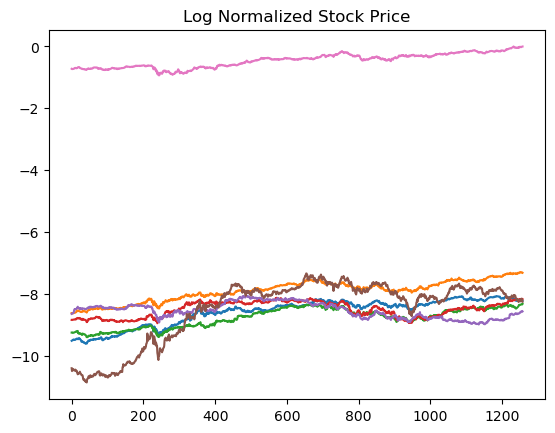

In [5]:
stock_array = np.array([t[1:] for t in stock_df.to_numpy()],dtype=float).T
stock_array=stock_array/np.max(stock_array)
plt.plot(np.log(stock_array).T)
plt.title('Log Normalized Stock Price')

In [6]:
mu = np.mean(stock_array,axis=1)
sigma= np.array([[np.cov(stock_array[i],stock_array[j])[0][1] for j in range(num_assets) ] for i in range(num_assets)])
B = 4
c = 0.1
sigma_mu=sigma- np.diag(mu)
A=sigma_mu+np.diag([-2*B*c for i in range(num_assets)])+c*np.ones((num_assets,num_assets))

In [8]:
mu

array([2.02116009e-04, 3.87973682e-04, 1.61399730e-04, 2.07707175e-04,
       2.00333985e-04, 2.83036018e-04, 6.52508927e-01])

In [7]:
import cvxpy as cp
x = cp.Variable(num_assets)
objective = cp.Minimize(x.T @ sigma @ x - x @ mu.T+c*(np.ones(num_assets).T @x - B)**2)
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)
result = prob.solve()
initial = x.value
initial

array([ 9.65629145e-02,  9.99996443e-01, -2.96397562e-06,  4.36352710e-01,
        4.68083137e-01,  9.99997186e-01,  9.99998775e-01])

In [8]:
def cost(x):
    return x.dot(A).dot(x)
from qiskit.quantum_info import SparsePauliOp

def indexedZ(i):
    return SparsePauliOp((num_assets-i-1)*'I' + 'Z' + 'I'*(i))

def indexedY(i):
    return SparsePauliOp((num_assets-i-1)*'I' + 'Y' + 'I'*(i))

def indexedX(i):
    return SparsePauliOp((num_assets-i-1)*'I' + 'X' + 'I'*(i))

from qiskit import QuantumCircuit
from functools import reduce
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.circuit import Parameter
H = 0 * SparsePauliOp('I' * num_assets)
for i in range(num_assets):
    for j in range(num_assets):
        H+=1/4 * A[i][j]* SparsePauliOp('I' * num_assets)-1/2 *  A[i][j]* indexedZ(i)+1/4 * A[i][j] * indexedZ(i) @ indexedZ(j)
H=H.simplify()


H_mix = reduce(lambda a,b: a+b, [indexedX(i) for i in range(num_assets)])
default_mixer = QuantumCircuit(num_assets)
default_mixer.append( PauliEvolutionGate(H_mix, Parameter('t')), range(num_assets))

from qiskit.circuit import ParameterVector
def QAOA_Ansatz(cost,mixer,p=1,initial=None):
    qc=QuantumCircuit(num_assets)
    if(initial is None):
        qc.h(range(num_assets))
    else:
        qc = initial.copy()
    Gamma = ParameterVector('γ',p)
    Beta = ParameterVector('β',p)
    for i in range(p):
        qc.append(PauliEvolutionGate(cost,Gamma[i]),range(num_assets))
        qc.append(mixer.assign_parameters([Beta[i]]),range(num_assets))
    return qc


In [9]:
def get_angle(c,epsilon):
    if(c<= epsilon):
        return 2*np.arcsin(np.sqrt(epsilon))
    elif(c>=1-epsilon):
        return 2*np.arcsin(np.sqrt(1-epsilon))
    else:
        return 2*np.arcsin(np.sqrt(c))

def WarmStartQAOA(initial,epsilon,cost,p=1):
    
    theta_list = [get_angle(i,epsilon) for i in initial]

    init_qc= QuantumCircuit(num_assets)
    mixer=QuantumCircuit(num_assets)

    t = Parameter('t')
    for i,v in enumerate(theta_list):
        init_qc.ry(v,i)
        mixer.ry(-v,i)
        mixer.rz(-2*t,i)
        mixer.ry(v,i)
    return QAOA_Ansatz(cost=cost,mixer=mixer,p=p,initial=init_qc)
        


In [18]:
epsilon=0
qaoa_ansatz = QAOA_Ansatz(H,default_mixer,p=1)
wsqaoa_ansatz = WarmStartQAOA(initial,epsilon,H,p=1)


In [19]:
qaoa_data = np.zeros((50,50))
wsqaoa_data = np.zeros((50,50))

In [20]:
from qiskit.quantum_info import Statevector
for i,x in enumerate(np.linspace(0,2*np.pi,50)):
    for j,y in enumerate(np.linspace(0,2*np.pi,50)):
        qaoa_data[i][j]=Statevector(qaoa_ansatz.assign_parameters([x,y])).expectation_value(H).real
        wsqaoa_data[i][j]=Statevector(wsqaoa_ansatz.assign_parameters([x,y])).expectation_value(H).real

In [25]:
from qiskit_algorithms.optimizers import COBYLA,SPSA
opt = COBYLA(maxiter=1000)

In [34]:
def run_opt(ansatz,reps=10):
    l=[]
    for i in range(reps):
        res = opt.minimize(lambda x: Statevector(ansatz.assign_parameters(x)).expectation_value(H).real,x0=np.random.random(ansatz.num_parameters))
        l.append(res.fun)
    return np.min(np.array(l)),np.max(np.array(l)),np.median(np.array(l))

In [38]:
wsqaoa_ansatz = WarmStartQAOA(initial,epsilon,H,p=1)
run_opt(wsqaoa_ansatz)

(-2.2098503461928494, -2.1958602132506293, -2.2026930743414876)

In [ ]:
(-2.181394170798905, -2.146675804600392, -2.159292015010576)
